In [149]:
import wave
import matplotlib.pyplot as plt
import numpy as np
import pyaudio
import time
import scipy
from scipy import stats
import bitstring

#from common import make_sine_wave, make_silence, bytes_to_arrays, normalized_wf_to_bytes, string_to_binary

import common as c

%matplotlib inline

In [5]:

fn = "signal1.wav"

wf = wave.open(fn, "rb")

data = wf.readframes(wf.getnframes())

sig = c.bytes_to_arrays( data , samplewidth=wf.getsampwidth(), channels=wf.getnchannels() )

fs = wf.getframerate()


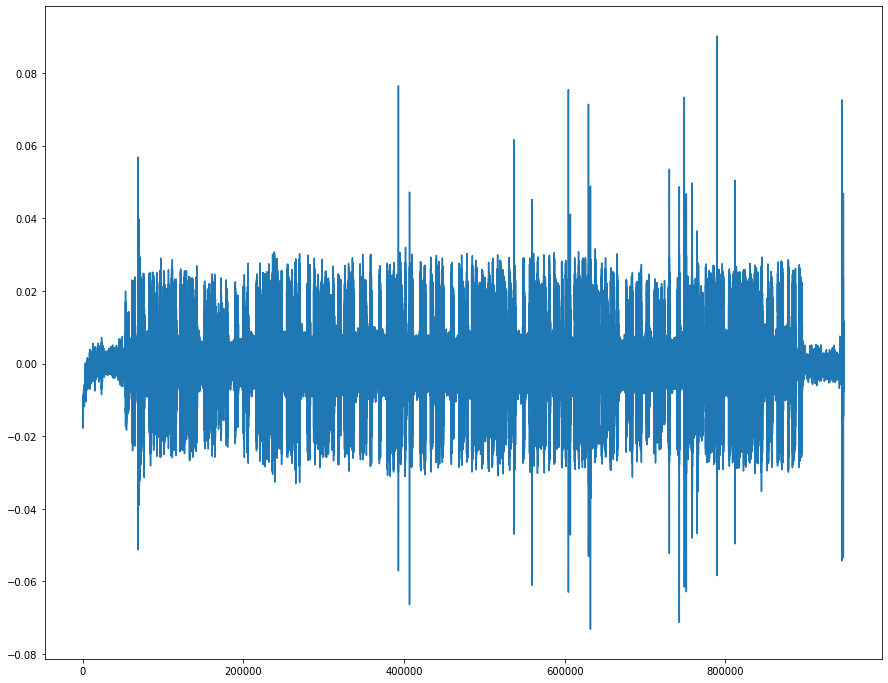

In [176]:
fig = plt.figure( figsize=(15,12))
plt.plot(sig)

0.0625


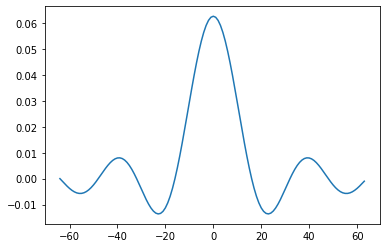

In [139]:
# I'm going to need to do a lot of filtering, let's start with sinc function for a low pass filter

n = np.array( range(-64,64) )

fc = 500  # CT cutoff frequency in hz
W = 2 * np.pi * fc / fs

print(W/np.pi)

h = W * np.sinc(n*W/np.pi)/np.pi

plt.plot( n, h )



In [24]:
# okay, the filters I need:


def sine_wave(f,fs,N):
    
    n = np.array( range(0,N) )
    
    return np.sin( 2*np.pi*n*f/fs )

    
def bpf(fc,fs):
    
    n = np.array( range(-127,128) )
    
    W = 2 * np.pi * fc / fs
    
    h = W * np.sinc(n*W/np.pi)/np.pi
    
    return h 


def plot_dft(h):

    # construct the x axis

    #freq = np.linspace(-np.pi,np.pi,1024)
    freq = np.linspace(0,1,512)*fs/2

    H = np.fft.ifft( h, n=1024 )

    #Hs = np.concatenate( [ H[512:], H[0:512] ] )
    Hs = H[0:512]

    fig = plt.figure( figsize=(15,6) )
    plt.plot( freq, np.absolute( Hs ) )




In [187]:
len(sig)

947494

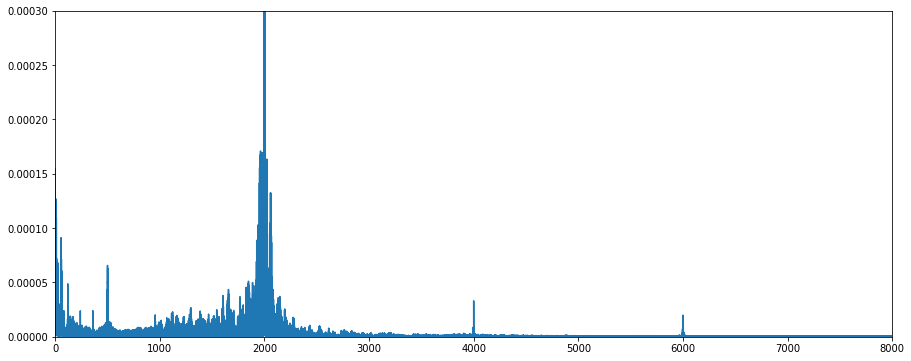

In [200]:
# spectrum of the "whole" signal

if True:
    
    # construct the x axis

    data_sig = sig[100000:900000]
    
    #freq = np.linspace(-np.pi,np.pi,1024)
    freq = np.linspace(0,1,len(data_sig))*fs

    H = np.fft.ifft( sig, n=len(data_sig) )

    #Hs = np.concatenate( [ H[512:], H[0:512] ] )
    Hs = H

    fig = plt.figure( figsize=(15,6) )
    plt.plot( freq, np.absolute( Hs ) )
    
    #plt.ylim([0,0.001])
    
    plt.ylim([0,0.0003])
    plt.xlim([0,8000])
    
    
#plt.figure()
#plt.plot(data_sig)

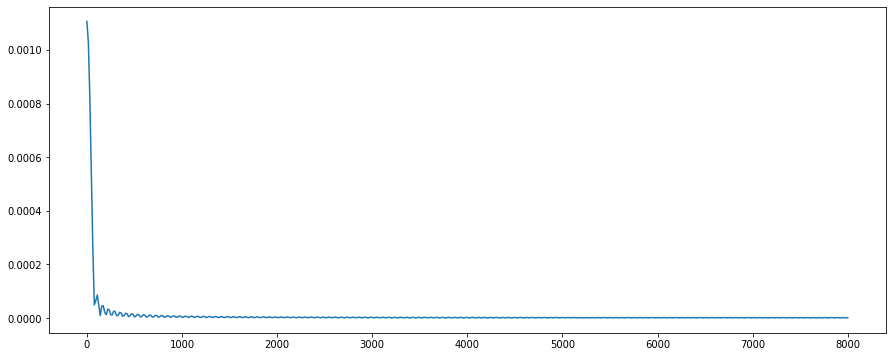

In [31]:
h_bp_500hz = bpf(525,fs) - bpf(475,fs)

h_lp_sync = bpf(50,fs)

plot_dft( h_lp_3hz )

<Figure size 1080x504 with 0 Axes>

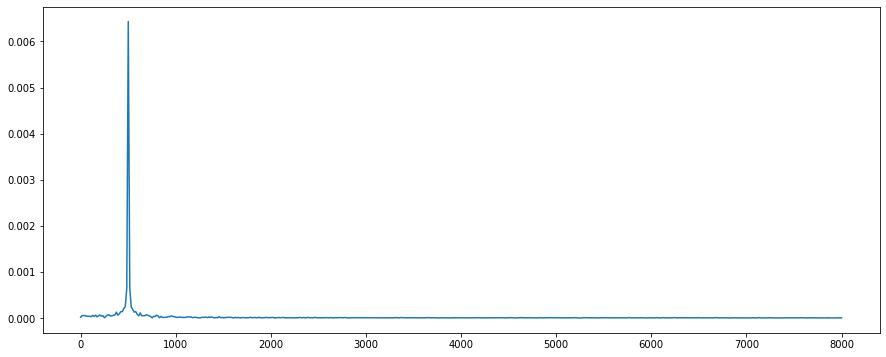

In [40]:
# this iswhat it looks like when I filter in the passband, rather changing to baseband

fig = plt.figure( figsize=(15,7))

sync_sig = sine_wave(500,fs,len(sig))

mixed_sig = np.multiply( sync_sig, sig )

baseband_sig = np.convolve( mixed_sig , h_lp_sync )

#y = np.convolve( sig, h_bp_500hz )

#y = np.convolve( sine_wave(60,fs,fs*2), h_lp_sync)

#plt.plot( y )

plot_dft( mixed_sig )

#plt.plot( baseband_sig )

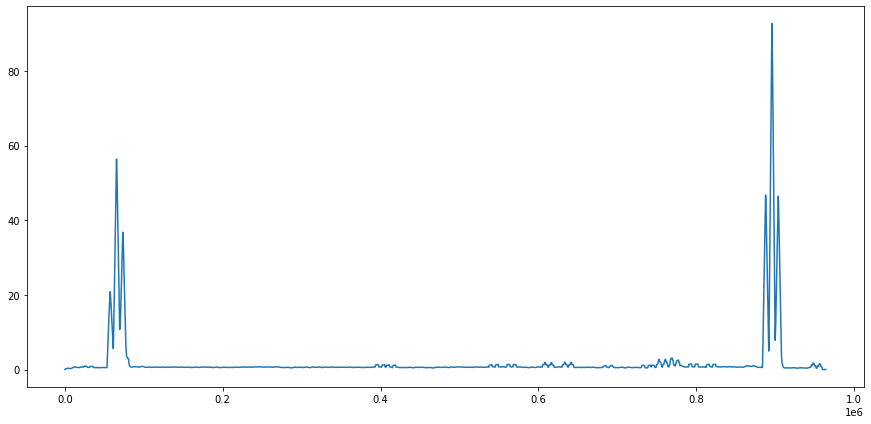

In [52]:
# let's try something simpler

marker_sig = np.concatenate( [ 
    np.ones( int(fs*0.25) ), 
    np.zeros( int(fs*0.25)), 
    np.ones( int(fs*0.25)), 
    np.zeros( int(fs*0.25) ) ] ) 

bl_sig = np.convolve( h_bp_500hz, sig )

rect_sig = np.abs(bl_sig)

baseband_sig = np.convolve( rect_sig, h_lp_sync )

fig = plt.figure( figsize=(15,7))
#plt.plot( baseband_sig )

marked_sig = np.convolve( baseband_sig, marker_sig )

plt.plot( marked_sig )


#plt.xlim([800000,1000000])

# I'm going to call this a win

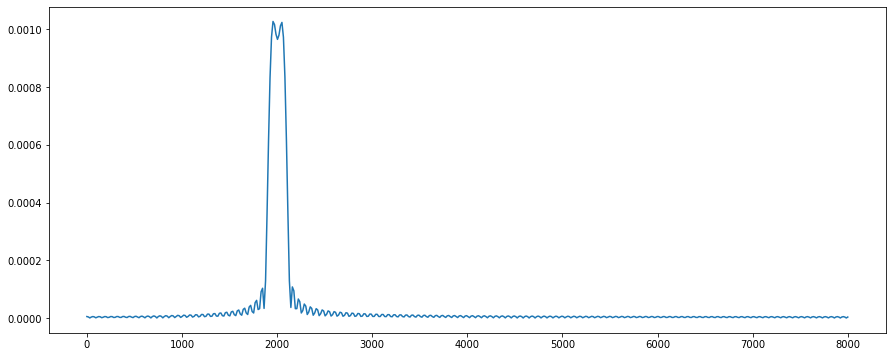

In [53]:
# now let's see whether we can get the data signal reasonably 

h_bp_carrier =  bpf(2100,fs) - bpf(1900,fs)

plot_dft( h_bp_carrier )

(400.0, 410.0)

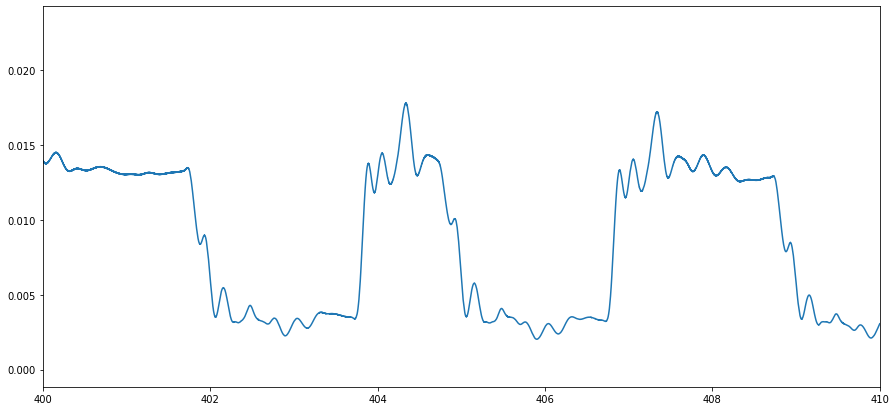

In [79]:

baud = 10

chip_period_in_samples = fs / baud

bp_carrier_sig = np.convolve( h_bp_carrier, sig )

fig = plt.figure( figsize=(15,7) ) 


rec_carrier_sig = np.absolute( bp_carrier_sig )

baseband_carrier_sig = np.convolve(rec_carrier_sig, h_lp_3hz )

plt.plot( np.array(range(0,len(baseband_carrier_sig) ))/chip_period_in_samples, baseband_carrier_sig )

#plt.plot( marked_sig / 4000 )

plt.xlim([400,410])

1560


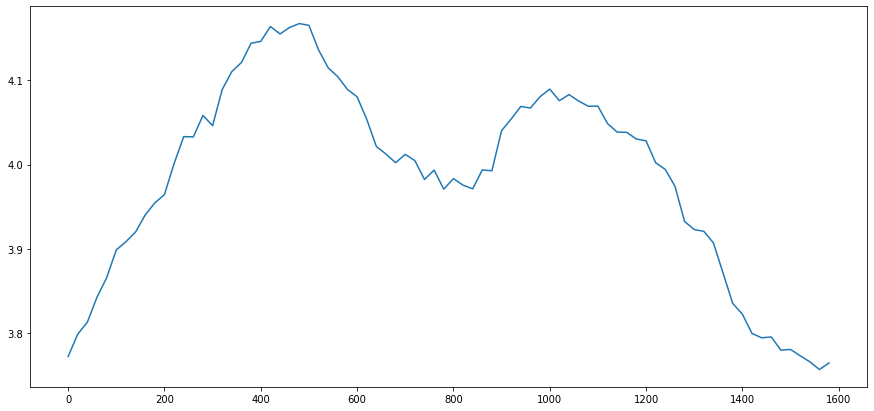

In [120]:
# let's see if we can extract the chips


chip_sig = np.ones( int( chip_period_in_samples ) )

matched_chip_sig = np.convolve( chip_sig, baseband_carrier_sig )


#plt.plot( y )

x = []
y = []

for n in range(0,1600,20):
    #fig = plt.figure( figsize=(15,7) ) 
    #dist = plt.hist( y[n::1600] , bins=np.linspace(0,30,100), histtype='step' ) 
    
    dist = np.histogram( matched_chip_sig[n::1600], bins=np.linspace(0,30,100) )
    
    entropy = stats.entropy( dist[0][3:] )
    
    x.append(n)
    y.append(entropy)
    
    #print(f"delay {n} entropy {entropy}")
    
    #plt.ylim([0,40])
    
fig = plt.figure( figsize=(15,7) )

plt.plot( x, y )

min_i = np.argmin(y)

#print(min_i)

delay = x[min_i]

print(delay)

(300000.0, 348000.0)

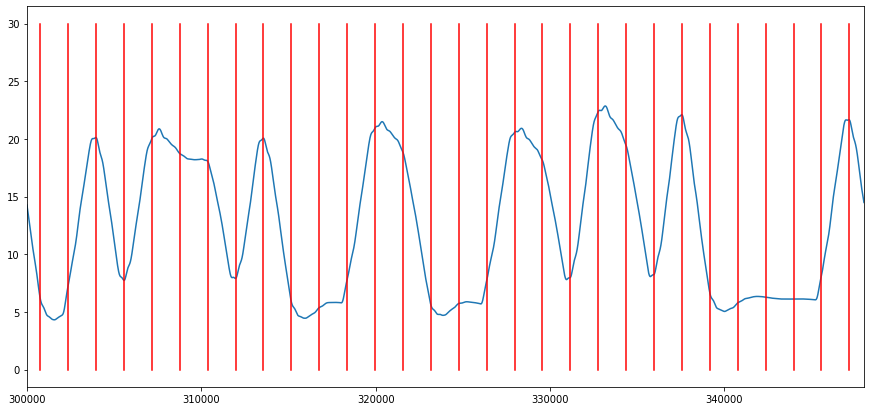

In [130]:
# next, let's plot the matched filter output with the chip boundaries on them

fig = plt.figure( figsize=(15,7) )

plt.plot( matched_chip_sig )

mark_loc = 300000
chip_marks = [ mark_loc, int(mark_loc+chip_period_in_samples*30) ]

for i in range( delay, len(matched_chip_sig), int(chip_period_in_samples) ):
    
    if i >= chip_marks[0] and i <= chip_marks[1]:
        plt.plot( [i, i], [0,30 ], 'r')
    
plt.xlim( chip_marks )

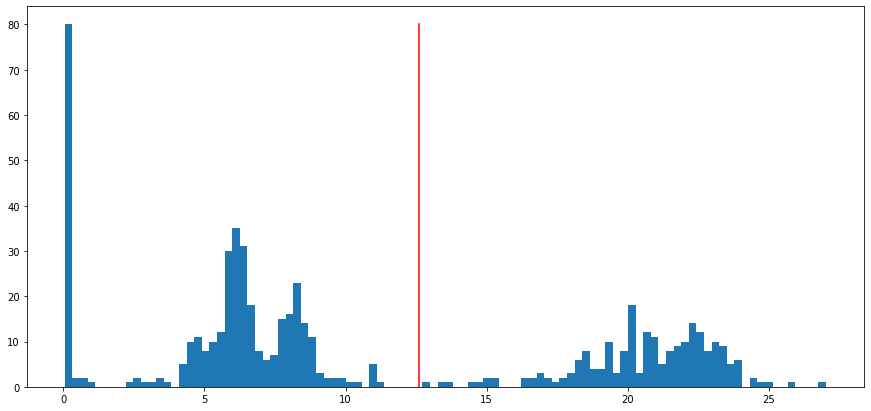

In [145]:
unthresholded_sig = matched_chip_sig[delay::int(chip_period_in_samples)]

# going to assume 1 and 0 have the same frequency

fig = plt.figure(figsize=(15,7))
dist = plt.hist( unthresholded_sig, bins=100);

idle_value = dist[1][3]

threshold = np.mean( unthresholded_sig[ unthresholded_sig > idle_value ] )

plt.plot( [ threshold, threshold ], [0, 80] ,'r')


In [146]:
ones_and_zeros = unthresholded_sig > threshold

In [168]:
# need to find the right offset, for now the one which allows UTF-8 to be decoded

fail = True

for o in range(0,len(ones_and_zeros) ):

    rem = len(ones_and_zeros[o:]) % 8
    end = len(ones_and_zeros[o:]) - rem + o
    
    ba = bitstring.BitArray( ones_and_zeros[o:end] )
    
    try:
        fail = False
        b = ba.bytes.decode("utf-8")
    except UnicodeDecodeError:
        fail = True
        
    if not fail:
        print(f"found it at {o} ")
        break

found it at 6 


In [170]:
print(b)

    Bryce i@ A sexy bitch. And Chicago is the greatest of all cities!!!     


In [171]:
len(b)

73

In [173]:
len(sig)/ (73*8)

1622.4212328767123